# MENDOCINO DATA SET 


In [1]:
!pip install seisbench pyproj seaborn

!pip install git+https://github.com/wayneweiqiang/GaMMA.git


  Cloning https://github.com/wayneweiqiang/GaMMA.git to /private/var/folders/5t/lvy1yscs2_s1nz4xfylhnxshq_ggr7/T/pip-req-build-ppqe2kxf
  Running command git clone --filter=blob:none --quiet https://github.com/wayneweiqiang/GaMMA.git /private/var/folders/5t/lvy1yscs2_s1nz4xfylhnxshq_ggr7/T/pip-req-build-ppqe2kxf
  Resolved https://github.com/wayneweiqiang/GaMMA.git to commit 21cda309aeb62bb17b4568304288dd4826483aca
  Preparing metadata (setup.py) ... done


In [2]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

In [3]:
import pandas as pd
from datetime import datetime, timedelta
from gamma import BayesianGaussianMixture, GaussianMixture
from gamma.utils import convert_picks_csv, association, from_seconds
import numpy as np
from sklearn.cluster import DBSCAN 
from datetime import datetime, timedelta
import os
import json
import pickle
from tqdm import tqdm
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from pyproj import CRS, Transformer, Proj
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from gamma.utils import association
import seisbench.models as sbm

sns.set(font_scale=1.2)
sns.set_style("ticks")

/Users/shwang/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Download Data 


In [5]:
# Get the current working directory
current_directory = os.getcwd()

# Check if the specified path exists
path = '/Users/shwang/Documents/Ferndale2022/EQT_20221220_20230103/catalog'
if os.path.exists(path):
    # If the path exists, open the file
    file_path = os.path.join(path, "catalog_new_ferndale_20221220_20221221.txt")
    x_file = open(file_path, "r")
    print("True")
else:
    print("False")

True


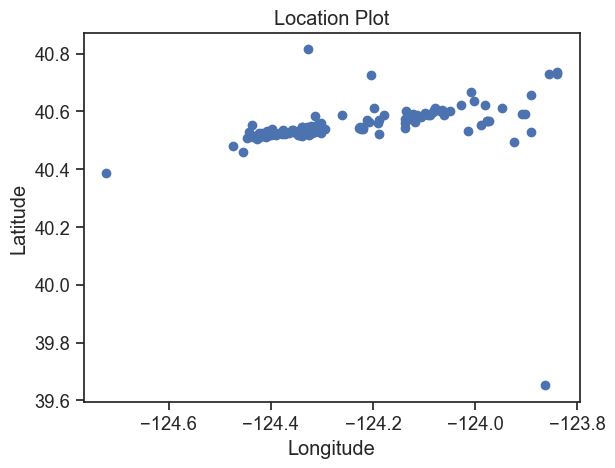

In [6]:
lat_df = []
long_df = []
for line in x_file:
    if not line.startswith('#'):  # Skip comment lines
        values = line.split()
        
        latitude = float(values[2])
        # print(latitude)
       
        longitude = float(values[3])
        # print(longitude)
        # latitude = lat_df.iloc[2:154, 'Latitude']
        # longitude = x_file.iloc[2:154, 'Longitude']
        lat_df.append(latitude)
        long_df.append(longitude)
        # print(lat_df)
        # print("long")
        # print(long_df)
plt.scatter(long_df, lat_df)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Location Plot')
plt.show()



## Station list

In [7]:
# Get the current working directory
current_directory = os.getcwd()

# Check if the specified path exists
path2 = '/Users/shwang/Documents/Ferndale2022'
if os.path.exists(path2):
    # If the path exists, open the file
    file_path2 = os.path.join(path2, "mendo_stations.txt")
    x_file = open(file_path2, "r")
    print("True")
else:
    print("False")

True


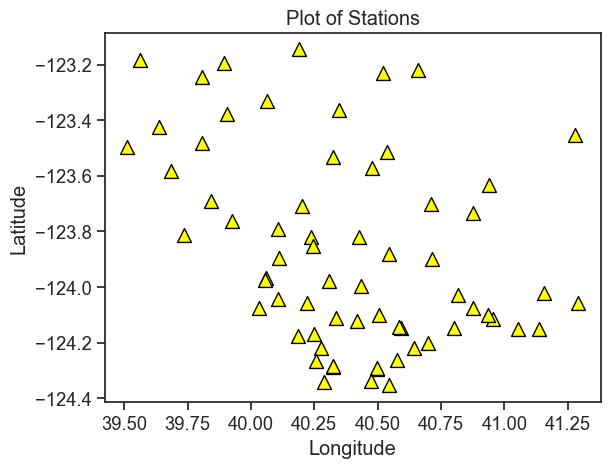

In [8]:

latStation_df = []
longStation_df = []

for line in x_file:
    values = line.split()
        
    latitude2 = float(values[0])
    longitude2 = float(values[1])
    
    latStation_df.append(latitude2)
    longStation_df.append(longitude2)

plt.figure()
plt.scatter(longStation_df, latStation_df, marker='^', color='yellow', edgecolor='black', s=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Stations')
plt.show()

# Combine the two maps

Graph Parameters make it so the graph doesn't display the full picture accurately

True
True


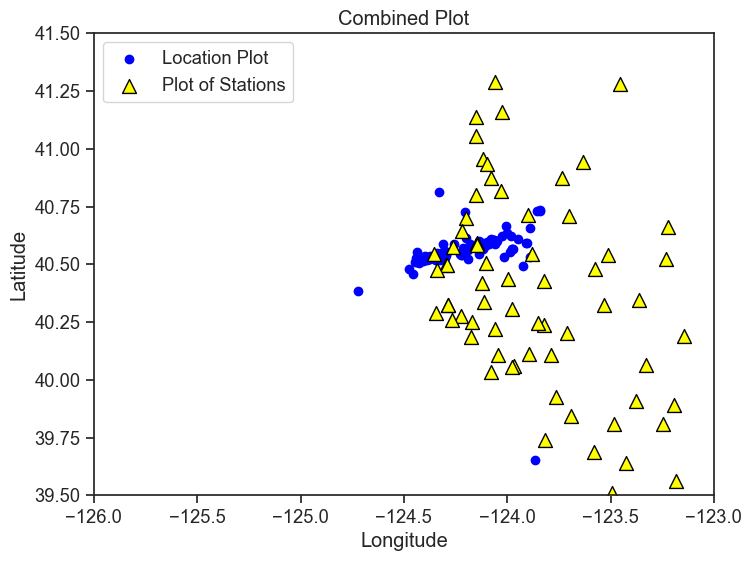

In [9]:
current_directory = os.getcwd()
path = '/Users/shwang/Documents/Ferndale2022/EQT_20221220_20230103/catalog'
if os.path.exists(path):
    file_path = os.path.join(path, "catalog_new_ferndale_20221220_20221221.txt")
    x_file = open(file_path, "r")
    print("True")
else:
    print("False")

lat_df = []
long_df = []
for line in x_file:
    if not line.startswith('#'):  # Skip comment lines
        values = line.split()

        latitude = float(values[2])
        longitude = float(values[3])

        lat_df.append(latitude)
        long_df.append(longitude)

x_file.close()
current_directory = os.getcwd()

path2 = '/Users/shwang/Documents/Ferndale2022'
if os.path.exists(path2):
    file_path2 = os.path.join(path2, "mendo_stations.txt")
    x_file2 = open(file_path2, "r")
    print("True")
else:
    print("False")
longStation_df = []
latStation_df = []

for line in x_file2:
    values = line.split()

    latitude2 = float(values[0])
    longitude2 = float(values[1])

    longStation_df.append(latitude2)
    latStation_df.append(longitude2)
x_file2.close()

plt.figure(figsize=(8, 6))

plt.scatter(long_df, lat_df, label='Location Plot', marker='o', color='blue')

plt.scatter(longStation_df, latStation_df, label='Plot of Stations', marker='^', color='yellow', edgecolor='black', s=100)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Combined Plot')
plt.legend()
plt.xlim([-126, -123])
plt.ylim([39.5, 41.5])
plt.show()

# Gamma on mseeds

Read in downloaded dataset

In [10]:
from obspy import read

In [11]:
# st = read("/Users/shwang/Documents/Ferndale2022/EQT_20221220_20230103/downloads_mseeds/20221220/KNEE/BK.KNEE.00.HHE__20221220T000000Z__20221221T000000Z.mseed")

st = read("/Users/shwang/Documents/Ferndale2022/EQT_20221220_20230103/downloads_mseeds/20221220/*/*.mseed")
print(st)

307 Trace(s) in Stream:

NP.1023..HNE | 2022-12-20T10:36:44.195000Z - 2022-12-20T10:41:17.995000Z | 200.0 Hz, 54761 samples
...
(305 other traces)
...
BK.RVIT.00.HHZ | 2022-12-20T23:57:50.000000Z - 2022-12-20T23:59:59.990000Z | 100.0 Hz, 13000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [12]:
print(st.__str__(extended=True))

307 Trace(s) in Stream:
NP.1023..HNE   | 2022-12-20T10:36:44.195000Z - 2022-12-20T10:41:17.995000Z | 200.0 Hz, 54761 samples
NP.1023..HNE   | 2022-12-20T10:51:48.000000Z - 2022-12-20T10:53:16.510000Z | 200.0 Hz, 17703 samples
NP.1023..HNE   | 2022-12-20T16:32:50.000000Z - 2022-12-20T16:34:33.170000Z | 200.0 Hz, 20635 samples
NP.1023..HNN   | 2022-12-20T10:36:44.195000Z - 2022-12-20T10:41:17.995000Z | 200.0 Hz, 54761 samples
NP.1023..HNN   | 2022-12-20T11:09:35.315000Z - 2022-12-20T11:11:08.995000Z | 200.0 Hz, 18737 samples
NP.1023..HNN   | 2022-12-20T16:32:50.000000Z - 2022-12-20T16:34:33.170000Z | 200.0 Hz, 20635 samples
NP.1023..HNZ   | 2022-12-20T10:36:44.195000Z - 2022-12-20T10:41:17.995000Z | 200.0 Hz, 54761 samples
NP.1023..HNZ   | 2022-12-20T10:51:48.000000Z - 2022-12-20T10:53:16.510000Z | 200.0 Hz, 17703 samples
NP.1580.10.HNE | 2022-12-20T00:00:00.000000Z - 2022-12-20T11:13:37.990000Z | 100.0 Hz, 4041800 samples
NP.1580.10.HNN | 2022-12-20T00:00:00.000000Z - 2022-12-20T11:13:3

In [13]:
print(st[0].stats) 

         network: NP
         station: 1023
        location: 
         channel: HNE
       starttime: 2022-12-20T10:36:44.195000Z
         endtime: 2022-12-20T10:41:17.995000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 54761
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 26, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 188416})


In [14]:
for k, v in sorted(st[0].stats.mseed.items()):
...     print("'%s': %s" % (k, str(v))) 

'byteorder': >
'dataquality': D
'encoding': STEIM2
'filesize': 188416
'number_of_records': 26
'record_length': 4096


In [15]:
t0 = UTCDateTime("2022/12/20 00:00:00")
t1 = UTCDateTime("2022/12/20 23:59:59")
client = Client("NCEDC") #ECEDC
# st = client.get_waveforms(network="BK", station="KNEE", location= "00", channel="HHE", starttime = t0, endtime = t1)
#         #stream = read.(mseedfile name)
#         #test by making a plot
inv = client.get_stations(network= "*", station="*", location= "*", channel="*", starttime = t0, endtime = t1, minlatitude = 39.5, maxlatitude = 41.5, minlongitude = -125, maxlongitude = -123)


In [16]:
wgs84 = CRS.from_epsg(4326)
local_crs = CRS.from_epsg(6417)  # california mendocino area
transformer = Transformer.from_crs(wgs84, local_crs)

# Gamma
config = {}
config = {'center': (-117.504, 35.705), #calculate center
    'xlim_degree': [-126, -123], #Long
    'ylim_degree': [39.5, 41.5], #lat
    'degree2km': 111.19492474777779, 
    'starttime': datetime(2022, 12, 20, 0, 0), 
    'endtime': datetime(2022, 12, 20, 0, 0)}

config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = False
config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km"]*np.cos(np.deg2rad(config["center"][1]))
config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
# config["x(km)"] = (1600, 2000)
# config["y(km)"] = (700, 900)
config["z(km)"] = (0, 40)
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}  # We assume rather high velocities as we expect deeper events
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 25  # seconds
config["dbscan_min_samples"] = 3

# Filtering
config["min_picks_per_eq"] = 5
config["max_sigma11"] = 2.0
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

In [17]:
picker = sbm.EQTransformer.from_pretrained("instance")

if torch.cuda.is_available():
    picker.cuda()

# We tuned the thresholds a bit - Feel free to play around with these values
picks, _ = picker.classify(st, batch_size=256, P_threshold=0.075, S_threshold=0.1, parallelism=1)

Counter([p.phase for p in picks])  # Output number of P and S picks

2023-08-14 08:12:46,401 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2023-08-14 08:58:10,041 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2023-08-14 08:58:10,042 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2023-08-14 08:59:15,112 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2023-08-14 14:06:23,470 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2023-08-14 14:06:23,471 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2023-08-14 14:06:23,471 | seisbench | WA

Counter({'P': 20339, 'S': 16396})

In [18]:
a = inv[0]
inv[0].code

'BK'

In [19]:
#test for latitude and long conv
pick_df = []
for p in picks:
    pick_df.append({
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })
pick_df = pd.DataFrame(pick_df)

station_df = []
for network in inv:
    for station in network:
        station_df.append({
            "id": f"{network.code}.{station.code}",
            "longitude": station.longitude,
            "latitude": station.latitude,
            "elevation(m)": station.elevation
        })
station_df = pd.DataFrame(station_df)

northing = {station: station_df.loc[station_df["id"] == station, "latitude"].values[0] for station in station_df["id"]}
station_dict = {station: (station_df.loc[station_df["id"] == station, "longitude"].values[0], station_df.loc[station_df["id"] == station, "latitude"].values[0]) for station in station_df["id"]}


In [20]:
#this one works
pick_df = []
for p in picks:
    temp_id = p.trace_id
    split_id = temp_id.split('.')
    # print(temp_id, split_id)
    out_id = split_id[0] + '.' + split_id[1]
    pick_df.append({
        # "id": p.trace_id,
        # "id": p.trace_id[:-3],
        
        # split_id = p.trace_id.split('.')
        #"id": out_id,
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
        
    })
pick_df = pd.DataFrame(pick_df)

station_df = []
for network in inv:
    for station in network:
        station_df.append({
            "id": f"{network.code}.{station.code}.",
            "longitude": station.longitude,
            "latitude": station.latitude,
            "elevation(m)": station.elevation
        })
station_df = pd.DataFrame(station_df)

station_df["x(km)"] = station_df.apply(lambda x: transformer.transform(x["latitude"], x["longitude"])[0] / 1e3, axis=1)
station_df["y(km)"] = station_df.apply(lambda x: transformer.transform(x["latitude"], x["longitude"])[1] / 1e3, axis=1)
station_df["z(km)"] = - station_df["elevation(m)"] / 1e3

northing = {station: y for station, y in zip(station_df["id"], station_df['longitude'])}
station_dict = {station: (x, y) for station, x, y in zip(station_df["id"], station_df['latitude'], station_df['longitude'])}

In [21]:
pick_df.sort_values("timestamp")

,id,timestamp,prob,type
0,NC.KIP.01,2022-12-20 00:00:40.010000,0.386775,p
1,NC.KIP.01,2022-12-20 00:00:44.440000,0.265480,s
2,PB.B934.,2022-12-20 00:01:07.298391,0.451979,s
16165,NC.KPR.01,2022-12-20 00:01:21.460000,0.175587,p
16166,NC.KRK.01,2022-12-20 00:01:31.780000,0.206154,p
...,...,...,...,...
36729,PB.B935.,2022-12-20 23:59:49.318393,0.211219,s
36730,PB.B932.,2022-12-20 23:59:49.628393,0.630948,s
36731,PB.B049.,2022-12-20 23:59:50.528396,0.440991,s
36732,NC.KPR.01,2022-12-20 23:59:50.740000,0.132760,s


In [22]:
print(station_df)

          id   longitude   latitude  elevation(m)        x(km)       y(km)  \
0   BK.BJES. -123.879960  40.543620        1050.7  1840.716413  821.046053   
1   BK.BLAS. -123.532480  40.322700        1679.3  1869.740546  795.960439   
2   BK.BRIC. -123.896500  40.112230         180.5  1838.315502  773.176322   
3   BK.DMOR. -123.703310  40.709730        1305.0  1856.027419  839.198844   
4   BK.GHOP. -123.977970  40.306430        1028.9  1831.840270  794.885312   
..       ...         ...        ...           ...          ...         ...   
68  PB.B049. -123.819702  40.237499         117.0  1845.140484  786.950621   
69  PB.B932. -124.221199  40.275002          52.0  1811.080429  791.873840   
70  PB.B933. -123.969002  40.060001         268.1  1832.009706  767.509434   
71  PB.B934. -123.691399  39.844501         331.0  1855.245811  743.108110   
72  PB.B935. -123.573196  40.478699         696.7  1866.579973  813.342581   

     z(km)  
0  -1.0507  
1  -1.6793  
2  -0.1805  
3  -1.3050 

In [31]:
# catalogs, assignments = association(pick_df, station_df, config, method=config["method"])

# catalog = pd.DataFrame(catalogs)

# catalogs[["longitude","latitude"]] = catalogs.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
# catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x*1e3)


# assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])

In [43]:
from pyproj import proj
event_idx0 = 0 ## current earthquake index
assignments = []
catalogs, assignments = association(pick_df, station_df, config, event_idx0, config["method"])
event_idx0 += len(catalogs)

## create catalog
catalogs = pd.DataFrame(catalogs, columns=["time"]+config["dims"]+["magnitude", "sigma_time", "sigma_amp", "cov_time_amp",  "event_index", "gamma_score"])
catalogs[["longitude","latitude"]] = catalogs.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x*1e3)

Associating 425 clusters with 11 CPUs
...............................................................................................................................................................................................................................................................................................................................................................................................

TypeError: 'module' object is not callable

In [38]:
catalog

,time,magnitude,sigma_time,sigma_amp,cov_time_amp,gamma_score,num_picks,num_p_picks,num_s_picks,event_index,x(km),y(km),z(km)
0,2022-12-20T11:50:19.199,999,0.723691,0,0,112.000000,5,5,0,0,-495.255296,645.374589,0.0
1,2022-12-20T17:03:29.488,999,0.947779,0,0,68.000000,5,5,0,1,-495.255296,645.374589,0.0
2,2022-12-20T13:41:45.261,999,1.059880,0,0,123.000000,7,7,0,6,-495.255296,645.374589,0.0
3,2022-12-20T16:22:29.719,999,0.690973,0,0,112.000000,6,6,0,2,-495.255296,645.374589,0.0
4,2022-12-20T15:54:28.579,999,0.514196,0,0,135.000000,5,2,3,8,-495.255296,645.374589,0.0
5,2022-12-20T20:44:53.968,999,0.832299,0,0,38.000000,6,6,0,4,-495.255296,420.984739,0.0
6,2022-12-20T20:38:55.257,999,1.098124,0,0,38.000000,5,0,5,5,-768.137007,645.374589,0.0
7,2022-12-20T09:28:10.604,999,0.875333,0,0,5.000000,5,0,5,3,-768.137007,645.374589,41.0
8,2022-12-20T14:54:41.972,999,1.589143,0,0,148.617425,5,2,3,14,-495.255296,645.374589,0.0
9,2022-12-20T14:56:01.321,999,0.533032,0,0,11.224961,6,4,2,15,-503.464455,645.374589,0.0


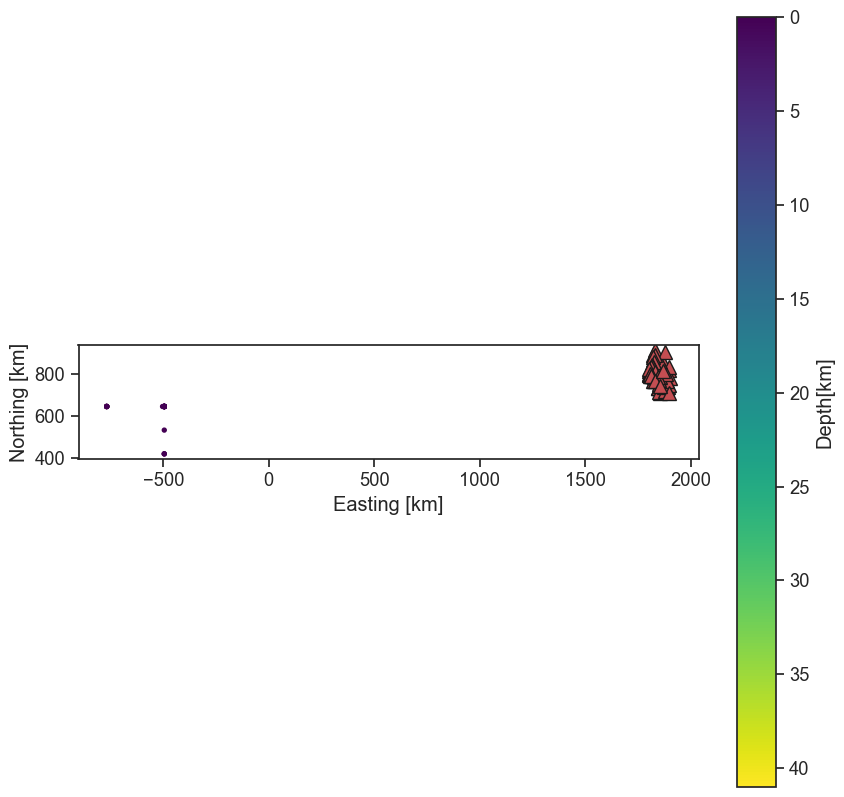

In [39]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
cb = ax.scatter(catalog["x(km)"], catalog["y(km)"], c=catalog["z(km)"], s=8, cmap="viridis")
cbar = fig.colorbar(cb)
cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])
cbar.set_label("Depth[km]")

ax.plot(station_df["x(km)"], station_df["y(km)"], "r^", ms=10, mew=1, mec="k")
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
plt.savefig('northing.png', dpi = 100)
plt.show()


In [40]:
# event_idx = np.random.randint(len(catalog))


# #for event_idx in range(1206):
# event_idx = 122
# event_picks = [picks[i] for i in assignments[assignments["event_index"] == event_idx]["pick_index"]]
# event = catalog.iloc[event_idx]

# first, last = min(pick.peak_time for pick in event_picks), max(pick.peak_time for pick in event_picks)

# sub = obspy.Stream()

# for station in np.unique([pick.trace_id for pick in event_picks]):
#     sub.append(st.select(station=station[3:-1], channel="*")[0])
# print(sub)
# sub = sub.slice(first - 5, last + 5)
# print(sub)
# sub = sub.copy()
# sub.detrend()
# sub.filter("highpass", freq=2)

# fig = plt.figure(figsize=(15, 10))
# ax = fig.add_subplot(111)

# for i, trace in enumerate(sub):
#     normed = trace.data - np.mean(trace.data)
#     normed = normed / np.max(np.abs(normed))
#     station_x, station_y = station_dict[trace.id[:-4]]
#     y = np.sqrt((station_x - event["x(km)"]) ** 2 + (station_y - event["y(km)"]) ** 2 + event["z(km)"] ** 2)
#     ax.plot(trace.times(), 10 * normed + y)

# for pick in event_picks:
#     print("pick:", pick.trace_id)
#     station_x, station_y = station_dict[pick.trace_id]
#     y = np.sqrt((station_x - event["x(km)"]) ** 2 + (station_y - event["y(km)"]) ** 2 + event["z(km)"] ** 2)
#     x = pick.peak_time - trace.stats.starttime
#     if pick.phase == "P":
#         ls = '-'
#     else:
#         ls = '--'
#     ax.plot([x, x], [y - 5, y + 5], 'k', ls=ls)

# ax.set_ylim(0)
# ax.set_xlim(0, np.max(trace.times()))
# ax.set_ylabel("Hypocentral distance [km]")
# ax.set_xlabel("Time [s]")
#     #plt.savefig("figures/event_waveform_"+str(event_idx)+".png", dpi = 100)
# print("Event information")
# print(event)

# uncomment in order to make events random and have pngs saved elsewhere


KeyError: 'longitude'

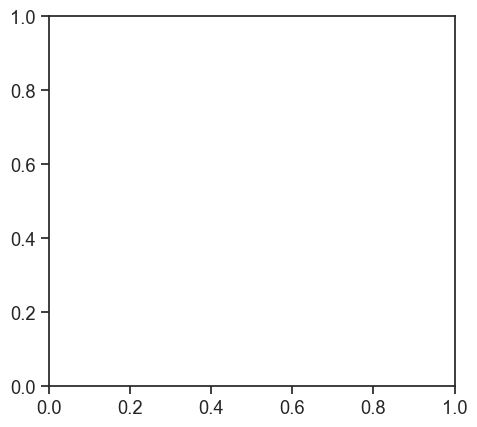

In [29]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(catalog["longitude"], catalog["latitude"], '.',markersize=2, alpha=1.0)
plt.plot(events["longitude"], events["latitude"], '.', markersize=2, alpha=0.6)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10, label=f"{result_label}", rasterized=True)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10, label=f"{catalog_label}", rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=5, alpha=0.7, label="Stations")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(catalog["longitude"], catalog["depth(m)"]/1e3, '.', markersize=2, alpha=1.0, rasterized=True)
plt.plot(events["longitude"], events["depth(m)"]/1e3, '.', markersize=2, alpha=0.6, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim([0,21])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, 31, '.', markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.plot(catalog["latitude"], catalog["depth(m)"]/1e3, '.', markersize=2, alpha=1.0, rasterized=True)
plt.plot(events["latitude"], events["depth(m)"]/1e3, '.', markersize=2, alpha=0.6, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.ylim([0,21])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0]-10, 31, '.', markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(figure_dir("earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show();

In [41]:
catalog_start_time = '2022-12-20T00:00:00'

fout = open(catalog, 'w')
with open(catalog, 'r') as fin:
    for line in fin:
      split_line = line.split()
      year = int(split_line[0])
      month = int(split_line[1])
      day = int(split_line[2])
      hour = int(split_line[3])
      minute = int(split_line[4])
      second = float(split_line[5])
      if (second >= 60.0):
         print("BEFORE: ", year, month, day, hour, minute, second)
         second -= 60.0
         minute += 1
         print("AFTER: ", year, month, day, hour, minute, second)
# fout = open(catalog, 'w')
# fout_nonclust = open(out_nonclust_file, 'w')
# with open(catalog, 'r') as fin:
#    for line in fin:
#       split_line = line.split()
#       year = int(split_line[0])
#       month = int(split_line[1])
#       day = int(split_line[2])
#       hour = int(split_line[3])
#       minute = int(split_line[4])
#       second = float(split_line[5])
#       if (second >= 60.0):
#          print("BEFORE: ", year, month, day, hour, minute, second)
#          second -= 60.0
#          minute += 1
#          print("AFTER: ", year, month, day, hour, minute, second)
#       origin_time_nosec = datetime.datetime(year, month, day, hour, minute)
#       origin_delta = datetime.timedelta(seconds=second)
#       origin_time = origin_time_nosec + origin_delta
#       num_sec = (origin_time - catalog_ref_time).total_seconds()
#       origin_str = datetime.datetime.strftime(origin_time, '%Y-%m-%dT%H:%M:%S.%f')
#       lat_deg = split_line[7]
#       lon_deg = split_line[8]
#       depth_km = split_line[9]
#       evid = int(split_line[6])
# #      mag = mag_map[evid]
#       mag = float(split_line[10])
#       nbranch = int(split_line[13]) # if nbranch==1 then not relocated, skip this event
#       if (nbranch != 1):
#          fout.write(("%s %f %s %s %s %s %d\n") % (origin_str, num_sec, lat_deg, lon_deg, depth_km, mag, evid))
# #         fout.write(("%f %s %s %s %s %d\n") % (num_sec, lat_deg, lon_deg, depth_km, mag, evid))
#       else:
#          fout_nonclust.write(("%s %f %s %s %s %s %d\n") % (origin_str, num_sec, lat_deg, lon_deg, depth_km, mag, evid))
# #         fout_nonclust.write(("%f %s %s %s %s %d\n") % (num_sec, lat_deg, lon_deg, depth_km, mag, evid))
# fout.close()
# fout_nonclust.close()


TypeError: unhashable type: 'DataFrame'